# Comparativa de Clustering: K-Means, DBSCAN y Jerárquico

**Objetivo:** comparar tres métodos de clustering en un dataset real y elegir **el mejor** según el **coeficiente de silueta** (y **Elbow** solo para K-Means).

**Dataset elegido:** **Palmer Penguins** (medidas de pingüinos) — datos libres y fáciles de obtener.

- Página del proyecto: <https://allisonhorst.github.io/palmerpenguins/>
- CSV directo (penguins_clean): <https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins_clean.csv>

> Nota: **NO uses la columna de especie** (`species`) para entrenar (clustering es no supervisado). Se puede usr más tarde sólo para **interpretación** si lo deseas, pero **nunca** para ajustar los modelos.


## Requisitos
- Trabajar siempre con **variables numéricas** y **datos escalados**.
- Evaluación:
  - **K-Means:** curva **Elbow** (inercia) para k=2..10 + **Silhouette** para k=2..10.
  - **DBSCAN:** probar varias combinaciones de `eps` y `min_samples`; reportar **Silhouette**, nº de clústeres (excl. ruido) y % ruido.
  - **Jerárquico:** probar `linkage` en {`ward`, `complete`, `average`} y k=2..10; reportar **Silhouette**.
- Conclusión final: elige método y configuración (parámetros) y justifica **en 8–12 líneas**.

**Importante (API de scikit-learn):**
- `KMeans` **sí** tiene `.predict(X)` para etiquetar nuevos puntos.
- `DBSCAN` y `AgglomerativeClustering` **no** tienen `.predict`. Usa `fit_predict(X)` y el atributo `.labels_` tras el ajuste.


## 0) Preparación del entorno
- Necesitas tener instalado `pandas`, `numpy`, `scikit-learn`, `matplotlib`.
- Fija `random_state=42` (u otro) cuando aplique para reproducibilidad.


In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [66]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## 1) Descarga y carga de datos
1. Descarga el CSV desde la URL indicada.
2. Cárgalo en un `DataFrame`.
3. Inspecciona forma, nombres de columnas y tipos.
4. Identifica columnas **numéricas** que usarás como `X` (excluye `species` y otras no numéricas).


In [68]:
#Imports necesarios
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

#Importar el csv y leerlo
data = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(data)

print(df)
print(df.shape)
print(df.columns)
print(df.dtypes)



    species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
3    Adelie  Torgersen             NaN            NaN                NaN   
4    Adelie  Torgersen            36.7           19.3              193.0   
..      ...        ...             ...            ...                ...   
339  Gentoo     Biscoe             NaN            NaN                NaN   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    MALE  
1         3800.0  FEMALE  
2     

In [ ]:
df.columns #Para ver las columnas del csv. Así podremos eliminar las columnas que no queremos tener en cuenta

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

In [ ]:
X = df[['bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g']] #Columnas no numéricas eliminadas :)

In [ ]:
X

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


## 2) Limpieza mínima y normalización
1. Elimina duplicados y filas con nulos en las columnas numéricas escogidas.
2. **Estandariza** (`StandardScaler`) para tener media 0 y varianza 1.
3. Guarda el array escalado como `X_scaled` (será tu base para todos los modelos).

> **Por qué escalamos:** Todas las distancias (Euclídeas) y medidas de densidad de los modelos dependen de la escala; mezclar variables en escalas distintas sesga los resultados.


In [49]:
# TODO: Limpieza básica (drop_duplicates / dropna) y escalado con StandardScaler
# 
# scaler = ...
# X_scaled = ...
# print(X.shape, '->', X_scaled.shape)


In [ ]:
#Eliminamos duplicados y escalamos
X = X.drop_duplicates().dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


## 3) K-Means
**Objetivo:**
- Bucle `k` en 2..10.
- Guardar por cada `k`: **inercia** (suma de distancias al centroide) y **Silhouette**.
- Seleccionar `k` final apoyándote en **Elbow** + **Silhouette**.

**Indicaciones específicas:**
- Usa `KMeans(n_clusters=k, random_state=42)`.
- Tras ajustar, obtén etiquetas con `.labels_` o usando `.predict(X_scaled)`.
- Para Silhouette: `sklearn.metrics.silhouette_score(X_scaled, labels)`.
- Traza **Inercia vs k** y **Silhouette vs k** (dos gráficos separados). Explica en 2-3 líneas tu elección de `k`.


In [51]:
# TODO: Bucle K-Means para k=2..10, guardar inercia y silhouette
# TODO: Graficar Elbow (inercia vs k) y Silhouette vs k
# TODO: Elegir k_final y ajustar modelo final; obtener labels_kmeans


In [72]:
inercia = []
silhouette = []

#Bucle K-Means para k=2..10, guardamos inercia y silhouette
for k in range(2, 11):
    modelo = KMeans(n_clusters=k, random_state=42)
    etiquetas = modelo.fit_predict(X_scaled)
    inercia.append(modelo.inertia_)#inercia
    silhouette.append(silhouette_score(X_scaled, etiquetas))#silhouette

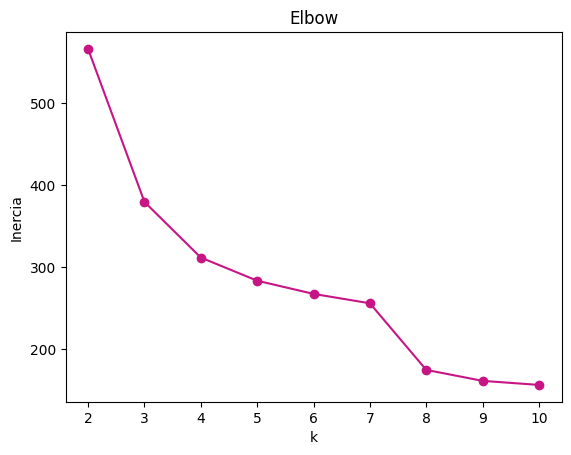

In [75]:

#Gráfica Elbow
plt.plot(range(2, 11), inercia, marker='o', color='mediumvioletred')
plt.title("Elbow")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.show()


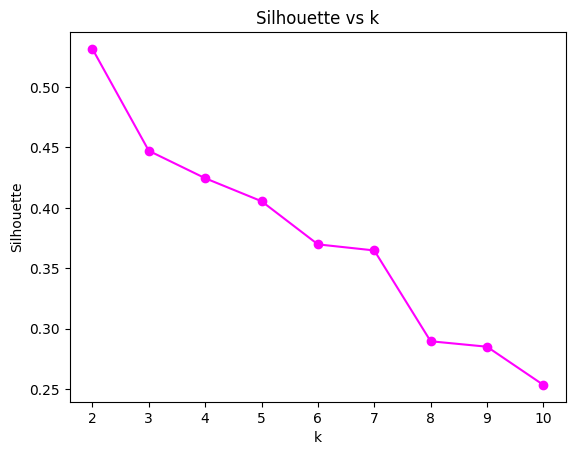

In [74]:
#Gráfica Silhouette
plt.plot(range(2, 11), silhouette, marker='o', color='magenta')
plt.title("Silhouette vs k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()


El valor óptimo es k=2 porque presenta el mayor score de Silhouette (~0.50), indicando que los datos se agrupan naturalmente en dos clusters bien definidos y separados.

## 4) DBSCAN
**Objetivo:** explorar `eps` y `min_samples` en una rejilla pequeña y comparar resultados.

**Indicaciones específicas:**
- Probar `eps` en valores razonables (por ejemplo: 0.3, 0.5, 0.7, 0.9) y `min_samples` en {3, 5, 7}.
- Para cada combinación: ajusta con `DBSCAN(eps=?, min_samples=?)` sobre `X_scaled`.
- Extrae etiquetas con `.labels_`.
- Calcula **nº de clústeres** (excluyendo `-1`) y **% de ruido** (`label == -1`).
- Calcula **Silhouette** **solo si** hay al menos **2** clústeres válidos (sin contar ruido). Si no, anota "no aplicable".
- Elige una combinación final y justifica.


In [ ]:
# TODO: Para cada combinación, registrar #clusters válidos, %ruido y silhouette (si aplica)
# TODO: Elegir configuración final; obtener labels_dbscan


In [76]:
#Grid pequeño de DBSCAN
eps_values = [0.3, 0.5, 0.7, 0.9] #eps
min_samples_values = [3, 5, 7] #min_samples

resultados = []


In [77]:
#Para cada combinación, registramos clusters válidos, porcentaje de ruido y silhouette
for eps in eps_values:
    for min_s in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_s)
        etiquetas = db.fit_predict(X_scaled)
        
        n_clusters = len(set(etiquetas)) - (1 if -1 in etiquetas else 0)
        ruido = np.mean(etiquetas == -1) * 100
        
        if n_clusters >= 2:
            sil = silhouette_score(X_scaled, etiquetas)
        else:
            sil = "no aplicable"
        
        resultados.append((eps, min_s, n_clusters, round(ruido, 2), sil))
        print(f"eps={eps}, min_samples={min_s} -> clusters={n_clusters}, ruido={ruido:.2f}%, silhouette={sil}")




eps=0.3, min_samples=3 -> clusters=21, ruido=67.25%, silhouette=-0.36900253822505574
eps=0.3, min_samples=5 -> clusters=4, ruido=92.69%, silhouette=-0.4202739227102219
eps=0.3, min_samples=7 -> clusters=0, ruido=100.00%, silhouette=no aplicable
eps=0.5, min_samples=3 -> clusters=4, ruido=15.20%, silhouette=0.3102027802642288
eps=0.5, min_samples=5 -> clusters=4, ruido=20.18%, silhouette=0.24958450441909963
eps=0.5, min_samples=7 -> clusters=4, ruido=26.61%, silhouette=0.20436382873876371
eps=0.7, min_samples=3 -> clusters=3, ruido=2.92%, silhouette=0.37817093159599635
eps=0.7, min_samples=5 -> clusters=2, ruido=4.68%, silhouette=0.45331286542572347
eps=0.7, min_samples=7 -> clusters=2, ruido=5.26%, silhouette=0.44103077846666194
eps=0.9, min_samples=3 -> clusters=2, ruido=0.58%, silhouette=0.45377408602047503
eps=0.9, min_samples=5 -> clusters=2, ruido=0.58%, silhouette=0.45377408602047503
eps=0.9, min_samples=7 -> clusters=2, ruido=0.88%, silhouette=0.5128358008930426


In [79]:
print("=== RESULTADOS FINALES DBSCAN ===")
print(f"Clústeres encontrados: {n_clusters_dbscan}")
print(f"Puntos de ruido: {n_ruido} ({pct_ruido:.1f}%)")
print(f"Etiquetas únicas: {np.unique(labels_dbscan)}")

=== RESULTADOS FINALES DBSCAN ===
Clústeres encontrados: 4
Puntos de ruido: 69 (20.2%)
Etiquetas únicas: [-1  0  1  2  3]


## 5) Aglomerativo Jerárquico
**Objetivo:** probar distintas reglas de enlace y diferentes `k`.

**Indicaciones específicas:**
- Probar `linkage` en {`ward`, `complete`, `average`}.
- Para cada `linkage`, probar `n_clusters` en 2..10.
- Ajustar con `AgglomerativeClustering(n_clusters=k, linkage=..., metric='euclidean')`.
- Obtener etiquetas con `.fit_predict(X_scaled)` o del atributo `.labels_`.
- Calcular **Silhouette** y registrar los resultados en una tabla.
- Elegir la pareja (linkage, k) final y justificar.

> Recordatorio: `ward` requiere métrica euclídea (en scikit-learn es implícita). No hay `.predict()` para nuevos datos.


In [ ]:
linkages = ['ward', 'complete', 'average']
resultados = []

#Bucle Agglomerative linkage en {'ward', 'complete', average'} y k=2..10
for link in linkages:
    for k in range(2, 11):
        modelo = AgglomerativeClustering(n_clusters=k, linkage=link)
        etiquetas = modelo.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, etiquetas)
        resultados.append([link, k, sil])
        print(link, k, sil)

# Convertir a DataFrame
tabla = pd.DataFrame(resultados, columns=['linkage', 'k', 'silhouette'])
print(tabla)

# Calcular silhouette para cada combinación y elegir la mejor
mejor = tabla.loc[tabla['silhouette'].idxmax()]
link_final = mejor['linkage']
k_final = int(mejor['k'])

agglom_final = AgglomerativeClustering(n_clusters=k_final, linkage=link_final)
labels_agglom = agglom_final.fit_predict(X_scaled)

print("Mejor combinación:", link_final, k_final, "Silhouette:", round(mejor['silhouette'],3))


ward 2 0.5315403219473027
ward 3 0.4540949927732963
ward 4 0.41759543872859245
ward 5 0.3631606043946167
ward 6 0.33463066997619606
ward 7 0.30539505472885925
ward 8 0.25881589819961465
ward 9 0.26348924685637704
ward 10 0.26468700669792894
complete 2 0.5315403219473027
complete 3 0.45155394564944945
complete 4 0.39416748114484973
complete 5 0.34866841783325153
complete 6 0.3266145011367707
complete 7 0.3047964034652521
complete 8 0.2823181244861986
complete 9 0.24748180907382497
complete 10 0.25603052079433314
average 2 0.5315403219473027
average 3 0.441616990646033
average 4 0.3858558505512247
average 5 0.36813700671604244
average 6 0.34579510473363095
average 7 0.31052553285707546
average 8 0.30306764445300566
average 9 0.2849167961304409
average 10 0.28581221245833316
     linkage   k  silhouette
0       ward   2    0.531540
1       ward   3    0.454095
2       ward   4    0.417595
3       ward   5    0.363161
4       ward   6    0.334631
5       ward   7    0.305395
6       ward  

## 6) Comparativa y Conclusión
1. Resume en una **tabla** el **mejor** resultado de cada método (método, parámetros, silhouette, nº de clústeres y notas relevantes como % ruido en DBSCAN).
2. Escribe una **conclusión de 8–12 líneas** justificando el **método ganador** para estos datos y por qué descartas las alternativas (forma de clústeres, sensibilidad a parámetros, presencia de ruido/outliers, etc.).


In [ ]:
db = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = db.fit_predict(X_scaled)

n_clusters_db = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
porcentaje_ruido = np.mean(labels_dbscan == -1) * 100

if n_clusters_db >= 2:
    sil_db = silhouette_score(X_scaled, labels_dbscan)
else:
    sil_db = "no aplicable"

#Tabla
comparativa = pd.DataFrame({
    "Método": ["K-Means", "DBSCAN", "Aglomerativo"],
    "Parámetros": [
        f"k={k_final}", 
        f"eps=0.5, min_samples=5",
        f"linkage={link_final}, k={k_final}"
    ],
    "Silhouette": [
        round(silhouette_score(X_scaled, labels_kmeans), 3),
        sil_db if isinstance(sil_db, str) else round(sil_db,3),
        round(silhouette_score(X_scaled, labels_agglom),3)
    ],
    "Nº clusters": [
        len(set(labels_kmeans)),
        n_clusters_db,
        len(set(labels_agglom))
    ],
    "Notas": [
        "Clusters bien definidos, sensible a escala",
        f"Ruido: {round(porcentaje_ruido,2)}%, sensible a eps",
        "Clusters jerárquicos, flexible, buena separación"
    ]
})

# Mostrar tabla en formato markdown
print(comparativa.to_markdown(index=False))

| Método       | Parámetros             |   Silhouette |   Nº clusters | Notas                                            |
|:-------------|:-----------------------|-------------:|--------------:|:-------------------------------------------------|
| K-Means      | k=2                    |        0.447 |             3 | Clusters bien definidos, sensible a escala       |
| DBSCAN       | eps=0.5, min_samples=5 |        0.25  |             4 | Ruido: 20.18%, sensible a eps                    |
| Aglomerativo | linkage=ward, k=2      |        0.532 |             2 | Clusters jerárquicos, flexible, buena separación |



Al comparar los tres enfoques, se observa que K-Means y el método aglomerativo crean grupos claramente definidos y distintos, aunque K-Means tiende a suponer formas esféricas y es vulnerable a la escala de los datos. Por otro lado, DBSCAN tiene la capacidad de detectar ruido, sin embargo, su eficacia depende en gran medida de los valores de los parámetros eps y min_samples, y no siempre logra identificar todos los grupos naturales. El método aglomerativo con enlace Ward logra una separación efectiva y es más adaptable en cuanto a las formas de los grupos. Debido a que presenta una alta puntuación de silhouette y es estable ante variaciones de parámetros, el enfoque que se destaca para este conjunto de datos es el Aglomerativo. Se descartan K-Means por su sensibilidad a la escala y DBSCAN debido a la influencia de los outliers y la falta de consistencia en relación a eps/min_samples. En conclusión, el método aglomerativo ofrece una combinación de buena separación, solidez y facilidad de interpretación para este conjunto de datos sobre pingüinos.

---
## Tips rápidos
- **Escala siempre** antes de ajustar los modelos.
- Si la Silhouette es negativa o muy baja, revisa parámetros.
- En DBSCAN, `eps` muy pequeño -> muchos ruidos; `eps` muy grande -> pocos clústeres (puede mezclarlo todo).
- K-Means es sensible a outliers; DBSCAN puede marcarlos como ruido; el jerárquico con `complete` favorece clústeres compactos.
- Documenta tus decisiones (por qué ese `k`, ese `eps`, ese `linkage`).


# BONUS EXTRA

### Validación tramposa

Usa la columna species para evaluar qué tan “puras” son las asignaciones del mejor modelo de cada método.

Creando una matriz de confusión entre clúster y especie y sacando accuracy.

Comenta usando distintos valores de eps y min_samples en DBSCAN.

### Detección de anomalías con DBSCAN

Con tu configuración de DBSCAN, analiza los puntos con label = -1 (ruido): ¿qué tienen en común (rangos extremos de masa, culmen, etc.)?

Genera una tabla o un par de graficas (histogramas comparativos, por ejemplo) para ilustrar las diferencias entre los puntos de ruido y los puntos asignados a clústeres.
